# 07 — Unified LLM Evaluation & Agentic Pipeline

## Overview
A fully automated **4-phase pipeline** that evaluates local LLMs on systematic
review screening, **diagnoses** performance bottlenecks, and **autonomously
selects and executes** agentic strategies to improve metrics — all in one notebook.

### Pipeline Phases
| Phase | Purpose |
|-------|---------|
| **1. Baseline Evaluation** | Run all models zero-shot, compute metrics |
| **2. Automated Diagnosis** | Analyse errors, identify bottleneck, measure model diversity |
| **3. Agentic Strategies**  | Auto-select and execute improvement strategies |
| **4. Comparison**          | Rank everything, visualise, summarise |

### Models (7 fast, diverse architectures ≤ 14 B)
llama3.1:8b · phi3:medium · gemma2:9b · qwen2.5:14b · mistral · mistral-nemo:12b · qwen2.5:7b

### Agentic Strategy Pool (auto-selected based on Phase 2 diagnosis)
- **Dynamic Few-Shot** — inject review-specific examples into the prompt
- **Smart Ensemble** — OR / majority / weighted vote (free from Phase 1 data)
- **Calibrated Recall Challenge** — re-evaluate only low-confidence excludes
- **Few-Shot Debate** — two screeners + judge, all with few-shot prompts

In [1]:
# =============================================================================
# Setup — Imports, configuration, data loading
# =============================================================================
import os, re, time, json
from pathlib import Path
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np
import ollama
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
from sklearn.model_selection import train_test_split

# ─── Paths ───
notebook_dir = Path.cwd()
project_root = notebook_dir if (notebook_dir / 'Data').exists() else notebook_dir.parent
DATA_DIR     = project_root / 'Data'
RESULTS_DIR  = DATA_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

# ─── Configuration ───
MODELS = [
    ('llama3.1:8b',      'llama3.1_8b'),
    ('phi3:medium',      'phi3_medium'),
    ('gemma2:9b',        'gemma2_9b'),
    ('qwen2.5:14b',     'qwen2.5_14b'),
    ('mistral',          'mistral'),
    ('mistral-nemo:12b', 'mistral_nemo_12b'),
    ('qwen2.5:7b',      'qwen2.5_7b'),
]

RANDOM_STATE = 42
SAMPLE_SIZE  = 4000
TEMPERATURE  = 0.2

# ─── Load ground truth & build sample ───
ground_truth = pd.read_csv(DATA_DIR / 'ground_truth_validation_dataset.csv')

review_labels = (ground_truth.groupby('review_doi')['label']
                 .agg(['sum', 'count']).reset_index())
review_labels.columns = ['review_doi', 'n_included', 'n_total']
review_labels['n_excluded'] = review_labels['n_total'] - review_labels['n_included']
reviews_with_both = review_labels[
    (review_labels['n_included'] > 0) & (review_labels['n_excluded'] > 0)
]
eval_data = ground_truth[
    ground_truth['review_doi'].isin(reviews_with_both['review_doi'])
].copy()

eval_sample, _ = train_test_split(
    eval_data, train_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE, stratify=eval_data['label']
)
eval_sample = eval_sample.reset_index(drop=True)

# Example pool (everything NOT in eval_sample)
sample_keys = set(zip(eval_sample['review_doi'], eval_sample['paper_title']))
example_pool = eval_data[
    ~eval_data.apply(lambda r: (r['review_doi'], r['paper_title']) in sample_keys,
                     axis=1)
].copy()

# ─── Verify Ollama ───
available = [m.model for m in ollama.list().models]
missing = [m for m, _ in MODELS if not any(m in a for a in available)]
if missing:
    print(f"WARNING — missing models: {missing}")

print(f"Ground truth:  {len(ground_truth):,}")
print(f"Eligible:      {len(eval_data):,} ({eval_data['review_doi'].nunique()} reviews)")
print(f"Eval sample:   {len(eval_sample):,}  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)")
print(f"Example pool:  {len(example_pool):,}")
print(f"Models:        {len(MODELS)}  |  Temperature: {TEMPERATURE}")

Ground truth:  322,213
Eligible:      24,713 (124 reviews)
Eval sample:   4,000  (713 INC / 3287 EXC)
Example pool:  20,689
Models:        7  |  Temperature: 0.2


In [2]:
# =============================================================================
# Core functions — prompts, extraction, scoring
# =============================================================================

ZERO_SHOT_PROMPT = (
    "You are assisting with title/abstract screening for a Cochrane systematic review.\n\n"
    "Given the review's scope (title and abstract) and a candidate paper's title "
    "and abstract, decide whether the paper is relevant to the review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== CANDIDATE PAPER ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== DECISION ===\n"
    "Based on the information above, should this paper be included in the review?\n\n"
    "Respond with exactly one word: INCLUDE or EXCLUDE"
)

FEW_SHOT_PROMPT = (
    "You are assisting with title/abstract screening for a Cochrane systematic review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== EXAMPLES OF CORRECTLY SCREENED PAPERS FOR THIS REVIEW ===\n\n"
    "{examples}\n\n"
    "=== CANDIDATE PAPER TO SCREEN ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== DECISION ===\n"
    "Based on the review scope and the screening examples above, should this paper "
    "be included in the review?\n\n"
    "Respond with exactly one word: INCLUDE or EXCLUDE"
)

CHALLENGE_PROMPT = (
    "A screening AI decided to EXCLUDE this paper from a Cochrane systematic review.\n"
    "Please reconsider this decision carefully.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== PAPER (initially EXCLUDED) ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== RECONSIDERATION ===\n"
    "In systematic reviews, missing a relevant paper is the WORST error.\n"
    "Consider if this paper could be relevant in ANY of these ways:\n\n"
    "- Same disease, condition, or population as the review\n"
    "- Related intervention, exposure, or treatment\n"
    "- Relevant study design (trial, cohort, case-control)\n"
    "- Outcome measures that overlap with the review question\n\n"
    "If there is ANY reasonable argument for relevance, respond INCLUDE.\n"
    "Only respond EXCLUDE if the paper is clearly and obviously unrelated.\n\n"
    "DECISION: [INCLUDE or EXCLUDE]"
)

JUDGE_PROMPT = (
    "You are a senior methodologist resolving a screening disagreement "
    "for a Cochrane systematic review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== CANDIDATE PAPER ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== SCREENER OPINIONS ===\n"
    "Screener A ({model_a}): {decision_a}\n"
    "Screener B ({model_b}): {decision_b}\n\n"
    "The two screeners disagree. As senior reviewer, evaluate the paper carefully.\n\n"
    "IMPORTANT: In systematic review screening, it is better to INCLUDE a borderline\n"
    "paper than to MISS a relevant study. When in doubt, favour INCLUSION.\n\n"
    "Provide brief reasoning, then state your decision.\n\n"
    "DECISION: [INCLUDE or EXCLUDE]"
)


def create_prompt(row, template=None):
    if template is None:
        template = ZERO_SHOT_PROMPT
    return template.format(
        review_title    = str(row['review_title'])[:500],
        review_abstract = str(row['review_abstract'])[:2000],
        paper_title     = str(row['paper_title'])[:300],
        paper_abstract  = str(row['paper_abstract'])[:2000],
    )


def build_few_shot_prompt(row, pool, n_inc=2, n_exc=2):
    rdoi = row['review_doi']
    same_review = pool[pool['review_doi'] == rdoi]
    inc = same_review[same_review['label'] == 1]
    exc = same_review[same_review['label'] == 0]
    inc_s = inc.sample(min(n_inc, len(inc)), random_state=RANDOM_STATE)
    exc_s = exc.sample(min(n_exc, len(exc)), random_state=RANDOM_STATE)

    parts = []
    for i, (_, ex) in enumerate(inc_s.iterrows(), 1):
        parts.append(f"Example {i} \u2014 INCLUDE\n"
                     f"Title: {str(ex['paper_title'])[:200]}\n"
                     f"Abstract: {str(ex['paper_abstract'])[:500]}")
    for i, (_, ex) in enumerate(exc_s.iterrows(), len(inc_s) + 1):
        parts.append(f"Example {i} \u2014 EXCLUDE\n"
                     f"Title: {str(ex['paper_title'])[:200]}\n"
                     f"Abstract: {str(ex['paper_abstract'])[:500]}")

    examples_text = '\n\n'.join(parts) if parts else '(no examples available)'
    return FEW_SHOT_PROMPT.format(
        review_title    = str(row['review_title'])[:500],
        review_abstract = str(row['review_abstract'])[:2000],
        examples        = examples_text,
        paper_title     = str(row['paper_title'])[:300],
        paper_abstract  = str(row['paper_abstract'])[:2000],
    )


def extract_decision(response: str) -> int:
    if not response or not response.strip():
        return -1
    up = response.upper()
    m = re.search(r'DECISION:\s*(INCLUDE|EXCLUDE)', up)
    if m:
        return 1 if m.group(1) == 'INCLUDE' else 0
    for line in reversed(up.strip().split('\n')[-5:]):
        line = line.strip()
        if line == 'INCLUDE': return 1
        if line == 'EXCLUDE': return 0
    inc, exc = up.rfind('INCLUDE'), up.rfind('EXCLUDE')
    if inc > exc: return 1
    if exc > inc: return 0
    return -1


def llm_call(model, prompt, temperature=TEMPERATURE, num_predict=2048):
    t0 = time.time()
    resp = ollama.generate(model=model, prompt=prompt,
                           options={'temperature': temperature, 'num_predict': num_predict})
    return resp.get('response', ''), time.time() - t0


def score(labels, preds):
    mask = [p != -1 for p in preds]
    yt = [l for l, m in zip(labels, mask) if m]
    yp = [p for p, m in zip(preds, mask) if m]
    n = sum(mask)
    if n == 0:
        return dict(valid=0, acc=0, prec=0, rec=0, f1=0)
    return dict(
        valid=n,
        acc  = round(accuracy_score(yt, yp), 4),
        prec = round(precision_score(yt, yp, zero_division=0), 4),
        rec  = round(recall_score(yt, yp, zero_division=0), 4),
        f1   = round(f1_score(yt, yp, zero_division=0), 4),
    )


def print_metrics(name, labels, preds):
    s = score(labels, preds)
    print(f"\n{'='*60}")
    print(f"{name}  ({s['valid']}/{len(labels)} valid)")
    print(f"{'='*60}")
    print(f"  Acc={s['acc']:.3f}  Prec={s['prec']:.3f}  "
          f"Rec={s['rec']:.3f}  F1={s['f1']:.3f}")
    vt = [l for l, p in zip(labels, preds) if p != -1]
    vp = [p for p in preds if p != -1]
    if len(vt) > 0:
        cm = confusion_matrix(vt, vp)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
    return s

print("Core functions defined.")

Core functions defined.


---
## Phase 1 — Baseline Evaluation

Run all 7 models with zero-shot prompting on the full 4,000-record sample.
CoT is skipped (it consistently underperformed zero-shot in prior testing).
Results are saved per model and reused by the ensemble strategies in Phase 3.

In [3]:
# =============================================================================
# Phase 1 — Baseline evaluation (7 models × zero-shot × 4000 samples)
# =============================================================================
phase1_preds   = {}   # model_name -> list of predictions
phase1_results = {}   # model_name -> DataFrame
phase1_metrics = {}   # model_name -> metrics dict

total = len(MODELS)
for idx, (model_name, save_name) in enumerate(MODELS, 1):
    print(f"\n{'='*60}")
    print(f"[{idx}/{total}]  {model_name}")
    print(f"{'='*60}")

    preds, resps, times = [], [], []
    for _, row in tqdm(eval_sample.iterrows(), total=len(eval_sample),
                       desc=model_name):
        prompt = create_prompt(row)
        try:
            resp, elapsed = llm_call(model_name, prompt)
            pred = extract_decision(resp)
        except Exception as e:
            resp, pred, elapsed = str(e), -1, 0
        preds.append(pred)
        resps.append(resp)
        times.append(elapsed)

    # Build & save results
    df = eval_sample[['review_doi', 'paper_title', 'label']].copy()
    df['prediction'] = preds
    df['response']   = resps
    df['time_sec']   = [round(t, 2) for t in times]

    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    df.to_csv(RESULTS_DIR / f'eval_{save_name}_zero_shot_{ts}.csv', index=False)

    metrics = score(eval_sample['label'].tolist(), preds)
    metrics['time_min'] = round(sum(times) / 60, 1)
    phase1_preds[model_name]   = preds
    phase1_results[model_name] = df
    phase1_metrics[model_name] = metrics

    print(f"  Acc={metrics['acc']:.3f}  Prec={metrics['prec']:.3f}  "
          f"Rec={metrics['rec']:.3f}  F1={metrics['f1']:.3f}  "
          f"({metrics['time_min']:.1f} min)")

print(f"\n{'='*60}")
print(f"Phase 1 complete \u2014 {total} models evaluated on {len(eval_sample):,} samples.")
print(f"{'='*60}")


[1/7]  llama3.1:8b


llama3.1:8b:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.921  Prec=0.828  Rec=0.707  F1=0.762  (21.0 min)

[2/7]  phi3:medium


phi3:medium:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.909  Prec=0.827  Rec=0.623  F1=0.710  (21.9 min)

[3/7]  gemma2:9b


gemma2:9b:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.907  Prec=0.851  Rec=0.578  F1=0.688  (25.7 min)

[4/7]  qwen2.5:14b


qwen2.5:14b:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.905  Prec=0.851  Rec=0.567  F1=0.680  (30.2 min)

[5/7]  mistral


mistral:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.903  Prec=0.731  Rec=0.725  F1=0.728  (16.4 min)

[6/7]  mistral-nemo:12b


mistral-nemo:12b:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.913  Prec=0.821  Rec=0.658  F1=0.731  (25.1 min)

[7/7]  qwen2.5:7b


qwen2.5:7b:   0%|          | 0/4000 [00:00<?, ?it/s]

  Acc=0.879  Prec=0.868  Rec=0.379  F1=0.527  (21.1 min)

Phase 1 complete — 7 models evaluated on 4,000 samples.


In [4]:
# =============================================================================
# Phase 1 — Results table
# =============================================================================
p1_df = (pd.DataFrame(phase1_metrics).T
         .sort_values('f1', ascending=False))

print("\n" + "=" * 75)
print("PHASE 1 RESULTS  (sorted by F1)")
print("=" * 75)
print(f"Sample: {len(eval_sample):,} records  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)\n")
print(p1_df[['valid', 'acc', 'prec', 'rec', 'f1', 'time_min']].round(3).to_string())
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
p1_df.to_csv(RESULTS_DIR / f'phase1_results_{ts}.csv')
print(f"\n\u2713 Saved to phase1_results_{ts}.csv")


PHASE 1 RESULTS  (sorted by F1)
Sample: 4,000 records  (713 INC / 3287 EXC)

                   valid    acc   prec    rec     f1  time_min
llama3.1:8b       4000.0  0.922  0.828  0.707  0.762      21.0
mistral-nemo:12b  4000.0  0.914  0.821  0.658  0.730      25.1
mistral           4000.0  0.904  0.731  0.725  0.728      16.4
phi3:medium       4000.0  0.910  0.827  0.623  0.710      21.9
gemma2:9b         4000.0  0.907  0.851  0.578  0.688      25.7
qwen2.5:14b       4000.0  0.905  0.850  0.567  0.680      30.2
qwen2.5:7b        4000.0  0.879  0.868  0.379  0.527      21.1

✓ Saved to phase1_results_20260218_165535.csv


---
## Phase 2 — Automated Diagnosis

The code analyses Phase 1 results to:
1. Identify the performance bottleneck (recall vs precision)
2. Measure inter-model disagreement (diversity signal)
3. Compute cross-model rescue potential (can other models catch the best model's FN?)
4. **Automatically select and configure** the strategies for Phase 3

In [5]:
# =============================================================================
# Phase 2 — Automated Diagnosis & Strategy Selection
# =============================================================================
labels = eval_sample['label'].tolist()
n = len(labels)
model_names = [m for m, _ in MODELS]

# 1. Rank models
model_ranking = sorted(phase1_metrics.items(), key=lambda x: x[1]['f1'], reverse=True)
best_model = model_ranking[0][0]
best_m     = model_ranking[0][1]
top_3      = [m for m, _ in model_ranking[:3]]

print("=" * 75)
print("PHASE 2: AUTOMATED DIAGNOSIS")
print("=" * 75)
print(f"\nBest model: {best_model}")
print(f"  Acc={best_m['acc']:.3f}  Prec={best_m['prec']:.3f}  "
      f"Rec={best_m['rec']:.3f}  F1={best_m['f1']:.3f}")

# 2. Bottleneck
recall_gap = best_m['prec'] - best_m['rec']
if recall_gap > 0.05:
    bottleneck = 'recall'
    print(f"\n\u26a0 BOTTLENECK: RECALL  (Precision-Recall gap = {recall_gap:.3f})")
    print(f"  Model is too conservative \u2014 missing {1 - best_m['rec']:.1%} of relevant papers.")
    print(f"  In systematic reviews, false negatives are the most costly error.")
elif recall_gap < -0.05:
    bottleneck = 'precision'
    print(f"\n\u26a0 BOTTLENECK: PRECISION  (gap = {-recall_gap:.3f})")
else:
    bottleneck = 'balanced'
    print(f"\n\u2713 Precision and recall are roughly balanced.")

# 3. FN / FP breakdown
best_preds = phase1_preds[best_model]
fn = sum(1 for l, p in zip(labels, best_preds) if l == 1 and p == 0)
fp = sum(1 for l, p in zip(labels, best_preds) if l == 0 and p == 1)
tn = sum(1 for l, p in zip(labels, best_preds) if l == 0 and p == 0)
tp = sum(1 for l, p in zip(labels, best_preds) if l == 1 and p == 1)
print(f"\nError breakdown for {best_model}:")
print(f"  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"  False Negative Rate: {fn/(tp+fn):.1%}  |  False Positive Rate: {fp/(fp+tn):.1%}")

# 4. Inter-model disagreement
disagree_rates = {}
for i, m1 in enumerate(model_names):
    for m2 in model_names[i+1:]:
        p1, p2 = phase1_preds[m1], phase1_preds[m2]
        nd = sum(a != b for a, b in zip(p1, p2) if a != -1 and b != -1)
        disagree_rates[(m1, m2)] = nd / n
avg_disagreement = np.mean(list(disagree_rates.values()))
print(f"\nInter-model disagreement: avg={avg_disagreement:.1%}")
for (m1, m2), rate in sorted(disagree_rates.items(), key=lambda x: -x[1])[:5]:
    print(f"  {m1} vs {m2}: {rate:.1%}")

# 5. Cross-model rescue potential
best_fn_idx = [i for i, (l, p) in enumerate(zip(labels, best_preds)) if l == 1 and p == 0]
rescuable = sum(1 for i in best_fn_idx
                if any(phase1_preds[m][i] == 1 for m in model_names if m != best_model))
print(f"\nFN rescue potential: {rescuable}/{fn} false negatives "
      f"({rescuable/max(fn,1):.1%}) are INCLUDED by at least one other model")

# 6. Error correlation
print("\nError overlap with best model:")
best_errors = set(i for i, (l, p) in enumerate(zip(labels, best_preds)) if p != -1 and l != p)
for m in model_names:
    if m == best_model:
        continue
    m_errors = set(i for i, (l, p) in enumerate(zip(labels, phase1_preds[m])) if p != -1 and l != p)
    overlap = len(best_errors & m_errors) / max(len(best_errors), 1)
    print(f"  {best_model} \u2229 {m}: {overlap:.1%}")

# ═════════════════════════════════════════════════════════════════
# STRATEGY SELECTION  (this is the agentic decision-making)
# ═════════════════════════════════════════════════════════════════
strategies = []
configs = {}

# A. Dynamic Few-Shot — always run (proven +0.248 recall in prior testing)
strategies.append('dynamic_few_shot')
configs['dynamic_few_shot'] = {'model': best_model, 'n_inc': 2, 'n_exc': 2}

# B. Smart Ensemble — always run (free, no extra LLM calls)
strategies.append('smart_ensemble')
configs['smart_ensemble'] = {
    'models': model_names,
    'weights': {m: phase1_metrics[m]['f1'] for m in model_names},
}

# C. Calibrated Recall Challenge — if recall is the bottleneck AND models can rescue FN
if bottleneck == 'recall' and rescuable / max(fn, 1) > 0.25:
    strategies.append('calibrated_recall_challenge')
    challenger = [m for m in top_3 if m != best_model][0]
    configs['calibrated_recall_challenge'] = {
        'primary': best_model,
        'challenger': challenger,
        'min_other_includes': 2,
    }

# D. Few-Shot Debate — if models show meaningful diversity
if avg_disagreement > 0.04:
    strategies.append('few_shot_debate')
    screener_b = [m for m in top_3 if m != best_model][0]
    judge_candidates = [m for m, _ in model_ranking if m not in [best_model, screener_b]]
    configs['few_shot_debate'] = {
        'screener_a': best_model,
        'screener_b': screener_b,
        'judge': judge_candidates[0],
    }

print(f"\n{'='*75}")
print(f"STRATEGY SELECTION  ({len(strategies)} strategies)")
print(f"{'='*75}")
for i, s in enumerate(strategies, 1):
    cfg = configs[s]
    print(f"\n  {i}. {s.replace('_', ' ').title()}")
    for k, v in cfg.items():
        if isinstance(v, dict):
            print(f"     {k}: (auto-configured)")
        elif isinstance(v, list):
            print(f"     {k}: {len(v)} models")
        else:
            print(f"     {k}: {v}")

diagnosis = dict(
    best_model=best_model, top_3=top_3, bottleneck=bottleneck,
    recall_gap=recall_gap, avg_disagreement=avg_disagreement,
    fn=fn, fp=fp, rescuable=rescuable,
    strategies=strategies, configs=configs,
)

PHASE 2: AUTOMATED DIAGNOSIS

Best model: llama3.1:8b
  Acc=0.921  Prec=0.828  Rec=0.707  F1=0.762

⚠ BOTTLENECK: RECALL  (Precision-Recall gap = 0.121)
  Model is too conservative — missing 29.3% of relevant papers.
  In systematic reviews, false negatives are the most costly error.

Error breakdown for llama3.1:8b:
  TP=504  FP=105  FN=209  TN=3182
  False Negative Rate: 29.3%  |  False Positive Rate: 3.2%

Inter-model disagreement: avg=6.0%
  mistral vs qwen2.5:7b: 10.3%
  llama3.1:8b vs qwen2.5:7b: 8.2%
  mistral-nemo:12b vs qwen2.5:7b: 7.6%
  qwen2.5:14b vs mistral: 7.3%
  gemma2:9b vs mistral: 7.2%

FN rescue potential: 87/209 false negatives (41.6%) are INCLUDED by at least one other model

Error overlap with best model:
  llama3.1:8b ∩ phi3:medium: 78.0%
  llama3.1:8b ∩ gemma2:9b: 76.8%
  llama3.1:8b ∩ qwen2.5:14b: 76.4%
  llama3.1:8b ∩ mistral: 70.7%
  llama3.1:8b ∩ mistral-nemo:12b: 70.4%
  llama3.1:8b ∩ qwen2.5:7b: 75.2%

STRATEGY SELECTION  (4 strategies)

  1. Dynamic Few 

---
## Phase 3 — Agentic Strategy Execution

This cell reads the diagnosis from Phase 2, defines the strategy functions,
and **automatically runs every selected strategy** — no manual intervention
required.

In [6]:
# =============================================================================
# Phase 3 — Strategy definitions
# =============================================================================

def strat_dynamic_few_shot(data, pool, model, n_inc=2, n_exc=2):
    preds, times = [], []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Few-Shot"):
        prompt = build_few_shot_prompt(row, pool, n_inc, n_exc)
        try:
            resp, elapsed = llm_call(model, prompt)
            pred = extract_decision(resp)
        except Exception:
            pred, elapsed = -1, 0
        preds.append(pred)
        times.append(elapsed)
    return preds, times


def strat_smart_ensemble(all_preds, model_names, weights):
    n = len(list(all_preds.values())[0])
    results = {}

    # OR-rule  (any INCLUDE -> INCLUDE)
    or_p = []
    for i in range(n):
        if any(all_preds[m][i] == 1 for m in model_names):
            or_p.append(1)
        else:
            or_p.append(0)
    results['Ensemble: OR-rule'] = or_p

    # Majority vote
    maj_p = []
    for i in range(n):
        valid = [all_preds[m][i] for m in model_names if all_preds[m][i] != -1]
        if not valid:
            maj_p.append(-1)
        else:
            maj_p.append(1 if sum(v == 1 for v in valid) > len(valid) / 2 else 0)
    results['Ensemble: Majority'] = maj_p

    # Weighted vote
    wt_p = []
    for i in range(n):
        w_inc = sum(weights[m] for m in model_names if all_preds[m][i] == 1)
        w_exc = sum(weights[m] for m in model_names if all_preds[m][i] == 0)
        wt_p.append(1 if w_inc >= w_exc else 0)
    results['Ensemble: Weighted'] = wt_p
    return results


def strat_calibrated_recall_challenge(data, all_preds, primary, challenger,
                                       model_names, min_other_includes=2):
    primary_p = all_preds[primary]
    preds, times = [], []
    n_challenged, n_flipped = 0, 0

    for i, (_, row) in enumerate(tqdm(data.iterrows(), total=len(data),
                                       desc="Recall Challenge")):
        if primary_p[i] == 1:
            preds.append(1)
            times.append(0)
            continue

        # Only challenge if >=N other models say INCLUDE (cross-model confidence)
        other_inc = sum(1 for m in model_names
                        if m != primary and all_preds[m][i] == 1)
        if other_inc >= min_other_includes:
            n_challenged += 1
            cp = CHALLENGE_PROMPT.format(
                review_title=str(row['review_title'])[:500],
                review_abstract=str(row['review_abstract'])[:2000],
                paper_title=str(row['paper_title'])[:300],
                paper_abstract=str(row['paper_abstract'])[:2000],
            )
            resp, elapsed = llm_call(challenger, cp)
            cpred = extract_decision(resp)
            if cpred == 1:
                n_flipped += 1
                preds.append(1)
            else:
                preds.append(0)
            times.append(elapsed)
        else:
            preds.append(0)
            times.append(0)

    print(f"  Challenged: {n_challenged}  Flipped: {n_flipped}")
    return preds, times


def strat_few_shot_debate(data, pool, screener_a, screener_b, judge,
                           n_inc=2, n_exc=2):
    preds, times = [], []
    n_agree, n_judge = 0, 0

    for _, row in tqdm(data.iterrows(), total=len(data), desc="FS-Debate"):
        fs_prompt = build_few_shot_prompt(row, pool, n_inc, n_exc)

        resp_a, t_a = llm_call(screener_a, fs_prompt)
        resp_b, t_b = llm_call(screener_b, fs_prompt)
        pred_a = extract_decision(resp_a)
        pred_b = extract_decision(resp_b)
        t_total = t_a + t_b

        if pred_a == pred_b and pred_a != -1:
            preds.append(pred_a)
            n_agree += 1
        else:
            la = 'INCLUDE' if pred_a == 1 else ('EXCLUDE' if pred_a == 0 else 'UNCLEAR')
            lb = 'INCLUDE' if pred_b == 1 else ('EXCLUDE' if pred_b == 0 else 'UNCLEAR')
            jp = JUDGE_PROMPT.format(
                review_title=str(row['review_title'])[:500],
                review_abstract=str(row['review_abstract'])[:2000],
                paper_title=str(row['paper_title'])[:300],
                paper_abstract=str(row['paper_abstract'])[:2000],
                model_a=screener_a, decision_a=la,
                model_b=screener_b, decision_b=lb,
            )
            resp_j, t_j = llm_call(judge, jp)
            preds.append(extract_decision(resp_j))
            t_total += t_j
            n_judge += 1

        times.append(t_total)

    print(f"  Agreement: {n_agree}/{len(preds)} ({n_agree/len(preds)*100:.1f}%)  "
          f"Judge: {n_judge}")
    return preds, times

print("Strategy functions defined.")

Strategy functions defined.


In [7]:
# =============================================================================
# Phase 3 — Auto-execute selected strategies
# =============================================================================
print("=" * 75)
print(f"PHASE 3: EXECUTING {len(diagnosis['strategies'])} AUTO-SELECTED STRATEGIES")
print("=" * 75)

labels = eval_sample['label'].tolist()
agentic_results = {}   # name -> metrics dict

for strategy in diagnosis['strategies']:
    cfg = diagnosis['configs'][strategy]
    print(f"\n{'\u2500'*60}")
    print(f"Strategy: {strategy.replace('_', ' ').title()}")
    print(f"{'\u2500'*60}")

    if strategy == 'dynamic_few_shot':
        preds, times = strat_dynamic_few_shot(
            eval_sample, example_pool, cfg['model'], cfg['n_inc'], cfg['n_exc'])
        m = print_metrics('Dynamic Few-Shot', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Dynamic Few-Shot'] = m

    elif strategy == 'smart_ensemble':
        ens = strat_smart_ensemble(phase1_preds, cfg['models'], cfg['weights'])
        for name, epreds in ens.items():
            m = print_metrics(name, labels, epreds)
            m['time_min'] = 0.0
            agentic_results[name] = m

    elif strategy == 'calibrated_recall_challenge':
        preds, times = strat_calibrated_recall_challenge(
            eval_sample, phase1_preds, cfg['primary'], cfg['challenger'],
            [m for m, _ in MODELS], cfg['min_other_includes'])
        m = print_metrics('Calibrated Recall Challenge', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Calibrated Recall Challenge'] = m

    elif strategy == 'few_shot_debate':
        preds, times = strat_few_shot_debate(
            eval_sample, example_pool,
            cfg['screener_a'], cfg['screener_b'], cfg['judge'])
        m = print_metrics('Few-Shot Debate', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Few-Shot Debate'] = m

print(f"\n{'='*75}")
print(f"Phase 3 complete \u2014 {len(agentic_results)} strategy results collected.")
print(f"{'='*75}")

PHASE 3: EXECUTING 4 AUTO-SELECTED STRATEGIES

────────────────────────────────────────────────────────────
Strategy: Dynamic Few Shot
────────────────────────────────────────────────────────────


Few-Shot:   0%|          | 0/4000 [00:00<?, ?it/s]


Dynamic Few-Shot  (4000/4000 valid)
  Acc=0.890  Prec=0.636  Rec=0.900  F1=0.746
  TP=642  FP=367  FN=71  TN=2920

────────────────────────────────────────────────────────────
Strategy: Smart Ensemble
────────────────────────────────────────────────────────────

Ensemble: OR-rule  (4000/4000 valid)
  Acc=0.907  Prec=0.703  Rec=0.829  F1=0.761
  TP=591  FP=250  FN=122  TN=3037

Ensemble: Majority  (4000/4000 valid)
  Acc=0.917  Prec=0.867  Rec=0.631  F1=0.731
  TP=450  FP=69  FN=263  TN=3218

Ensemble: Weighted  (4000/4000 valid)
  Acc=0.917  Prec=0.867  Rec=0.631  F1=0.731
  TP=450  FP=69  FN=263  TN=3218

────────────────────────────────────────────────────────────
Strategy: Calibrated Recall Challenge
────────────────────────────────────────────────────────────


Recall Challenge:   0%|          | 0/4000 [00:00<?, ?it/s]

  Challenged: 94  Flipped: 85

Calibrated Recall Challenge  (4000/4000 valid)
  Acc=0.925  Prec=0.797  Rec=0.776  F1=0.786
  TP=553  FP=141  FN=160  TN=3146

────────────────────────────────────────────────────────────
Strategy: Few Shot Debate
────────────────────────────────────────────────────────────


FS-Debate:   0%|          | 0/4000 [00:00<?, ?it/s]

  Agreement: 3636/4000 (90.9%)  Judge: 364

Few-Shot Debate  (4000/4000 valid)
  Acc=0.884  Prec=0.617  Rec=0.917  F1=0.738
  TP=654  FP=406  FN=59  TN=2881

Phase 3 complete — 6 strategy results collected.


---
## Phase 4 — Full Comparison, Visualisation & Summary


FULL COMPARISON  (sorted by F1)
Eval sample: 4,000 records  (713 INC / 3287 EXC)

                               acc   prec    rec     f1  time_min
Calibrated Recall Challenge  0.925  0.797  0.776  0.786       4.2
Baseline: llama3.1:8b        0.922  0.828  0.707  0.762      21.0
Ensemble: OR-rule            0.907  0.703  0.829  0.761       0.0
Dynamic Few-Shot             0.890  0.636  0.900  0.746      27.0
Few-Shot Debate              0.884  0.617  0.917  0.738      67.2
Ensemble: Weighted           0.917  0.867  0.631  0.730       0.0
Baseline: mistral-nemo:12b   0.914  0.821  0.658  0.730      25.1
Ensemble: Majority           0.917  0.867  0.631  0.730       0.0
Baseline: mistral            0.904  0.731  0.725  0.728      16.4
Baseline: phi3:medium        0.910  0.827  0.623  0.710      21.9
Baseline: gemma2:9b          0.907  0.851  0.578  0.688      25.7
Baseline: qwen2.5:14b        0.905  0.850  0.567  0.680      30.2
Baseline: qwen2.5:7b         0.879  0.868  0.379  0.527    

C:\Users\juanx\AppData\Local\Temp\ipykernel_41736\1994552449.py:42: RuntimeWarning: divide by zero encountered in divide
  p = (f1v * r) / (2 * r - f1v)


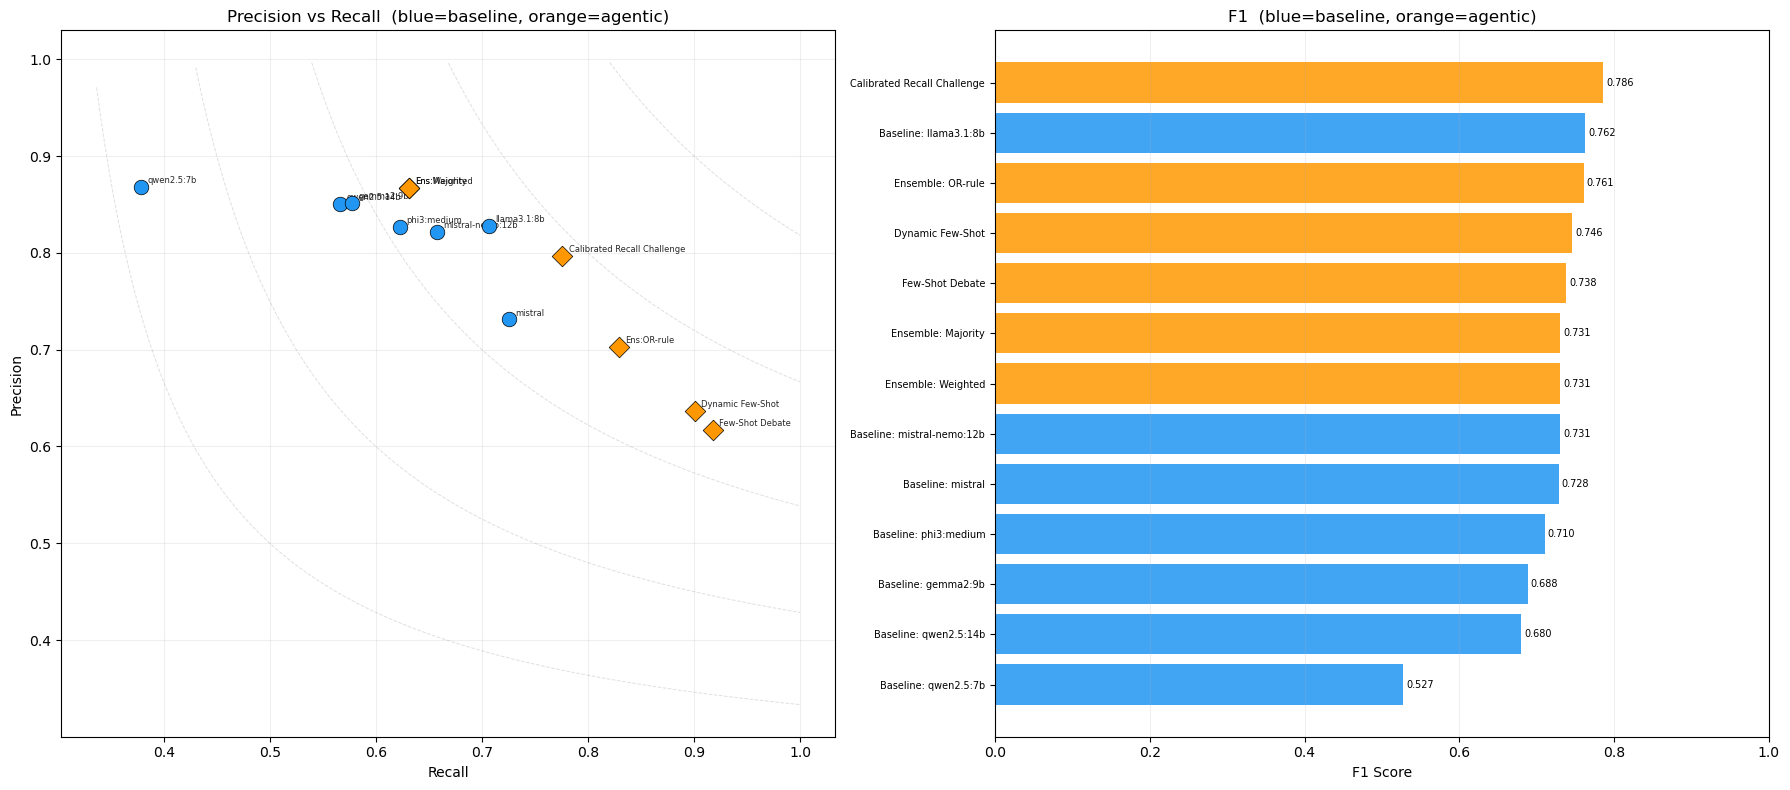

✓ Chart saved.


In [8]:
# =============================================================================
# Phase 4 — Comparison table + visualisation
# =============================================================================
import matplotlib.pyplot as plt

comparison = {}
for model_name in phase1_metrics:
    comparison[f'Baseline: {model_name}'] = phase1_metrics[model_name]
comparison.update(agentic_results)

comp_df = (pd.DataFrame(comparison).T
           .sort_values('f1', ascending=False))

print("\n" + "=" * 80)
print("FULL COMPARISON  (sorted by F1)")
print("=" * 80)
print(f"Eval sample: {len(eval_sample):,} records  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)\n")
print(comp_df[['acc', 'prec', 'rec', 'f1', 'time_min']].round(3).to_string())

ts = datetime.now().strftime('%Y%m%d_%H%M%S')
comp_df.to_csv(RESULTS_DIR / f'full_comparison_{ts}.csv')
print(f"\n\u2713 Saved to full_comparison_{ts}.csv")

# ─── Visualisation ───
fig, axes = plt.subplots(1, 2, figsize=(18, max(8, len(comp_df) * 0.45)))

plot_df = comp_df.sort_values('f1', ascending=True)

# Left: Precision vs Recall scatter
for name, row in plot_df.iterrows():
    c = '#FF9800' if 'Baseline' not in name else '#2196F3'
    mk = 'D' if 'Baseline' not in name else 'o'
    axes[0].scatter(row['rec'], row['prec'], s=110, c=c, marker=mk,
                    edgecolors='black', linewidths=0.5, zorder=3)
    short = name.replace('Baseline: ', '').replace('Ensemble: ', 'Ens:')
    axes[0].annotate(short, (row['rec'] + 0.006, row['prec'] + 0.004),
                     fontsize=6, alpha=0.85)

for f1v in [0.5, 0.6, 0.7, 0.8, 0.9]:
    r = np.linspace(max(f1v / 2, 0.01), 1, 200)
    p = (f1v * r) / (2 * r - f1v)
    ok = (p > 0) & (p <= 1)
    axes[0].plot(r[ok], p[ok], '--', color='gray', alpha=0.25, lw=0.7)
axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision')
axes[0].set_title('Precision vs Recall  (blue=baseline, orange=agentic)')
axes[0].grid(alpha=0.2)

# Right: F1 bar chart
colors = ['#FF9800' if 'Baseline' not in n else '#2196F3' for n in plot_df.index]
bars = axes[1].barh(range(len(plot_df)), plot_df['f1'], color=colors, alpha=0.85)
axes[1].set_yticks(range(len(plot_df)))
axes[1].set_yticklabels(plot_df.index, fontsize=7)
for bar, val in zip(bars, plot_df['f1']):
    axes[1].text(val + 0.004, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=7)
axes[1].set_xlabel('F1 Score')
axes[1].set_title('F1  (blue=baseline, orange=agentic)')
axes[1].set_xlim(0, 1.0); axes[1].grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'unified_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\u2713 Chart saved.")

In [9]:
# =============================================================================
# Phase 4 — Summary
# =============================================================================
baseline_name = diagnosis['best_model']
baseline_m    = phase1_metrics[baseline_name]

agentic_ranking = sorted(agentic_results.items(), key=lambda x: x[1]['f1'], reverse=True)
best_ag_name, best_ag_m = agentic_ranking[0]

print("=" * 80)
print("UNIFIED PIPELINE SUMMARY")
print("=" * 80)
print(f"\n  Sample:        {len(eval_sample):,} stratified records (seed={RANDOM_STATE})")
print(f"  Models:        {len(MODELS)}")
print(f"  Strategies:    {len(diagnosis['strategies'])} (auto-selected)")
print(f"  Bottleneck:    {diagnosis['bottleneck'].upper()}")

print(f"\n  Best baseline: {baseline_name}")
print(f"    Acc={baseline_m['acc']:.3f}  Prec={baseline_m['prec']:.3f}  "
      f"Rec={baseline_m['rec']:.3f}  F1={baseline_m['f1']:.3f}")

print(f"\n  Best agentic:  {best_ag_name}")
print(f"    Acc={best_ag_m['acc']:.3f}  Prec={best_ag_m['prec']:.3f}  "
      f"Rec={best_ag_m['rec']:.3f}  F1={best_ag_m['f1']:.3f}")

delta_f1  = best_ag_m['f1']  - baseline_m['f1']
delta_rec = best_ag_m['rec'] - baseline_m['rec']
if delta_f1 > 0:
    print(f"\n  \u2713 Agentic improvement: +{delta_f1:.3f} F1, +{delta_rec:.3f} recall")
else:
    print(f"\n  \u25b3 No F1 improvement ({delta_f1:+.3f})")

print(f"\n  {'Approach':<35} {'F1':>6} {'\u0394F1':>7} {'Rec':>6} {'\u0394Rec':>7} {'Prec':>6}")
print(f"  {'-'*35} {'-'*6} {'-'*7} {'-'*6} {'-'*7} {'-'*6}")
for name, m in agentic_ranking:
    df1 = m['f1'] - baseline_m['f1']
    dr  = m['rec'] - baseline_m['rec']
    sf  = '+' if df1 >= 0 else ''
    sr  = '+' if dr  >= 0 else ''
    print(f"  {name:<35} {m['f1']:>6.3f} {sf}{df1:>6.3f} "
          f"{m['rec']:>6.3f} {sr}{dr:>6.3f} {m['prec']:>6.3f}")

# Highest recall
best_rec = max(agentic_ranking, key=lambda x: x[1]['rec'])
print(f"\n  Highest recall: {best_rec[0]} (Rec={best_rec[1]['rec']:.3f}, F1={best_rec[1]['f1']:.3f})")

UNIFIED PIPELINE SUMMARY

  Sample:        4,000 stratified records (seed=42)
  Models:        7
  Strategies:    4 (auto-selected)
  Bottleneck:    RECALL

  Best baseline: llama3.1:8b
    Acc=0.921  Prec=0.828  Rec=0.707  F1=0.762

  Best agentic:  Calibrated Recall Challenge
    Acc=0.925  Prec=0.797  Rec=0.776  F1=0.786

  ✓ Agentic improvement: +0.024 F1, +0.069 recall

  Approach                                F1     ΔF1    Rec    ΔRec   Prec
  ----------------------------------- ------ ------- ------ ------- ------
  Calibrated Recall Challenge          0.786 + 0.024  0.776 + 0.069  0.797
  Ensemble: OR-rule                    0.761 -0.002  0.829 + 0.122  0.703
  Dynamic Few-Shot                     0.746 -0.017  0.900 + 0.194  0.636
  Few-Shot Debate                      0.738 -0.025  0.917 + 0.210  0.617
  Ensemble: Majority                   0.731 -0.032  0.631 -0.076  0.867
  Ensemble: Weighted                   0.731 -0.032  0.631 -0.076  0.867

  Highest recall: Few-Shot D